In [ ]:
import os

os.chdir("/home/unix/SmartBinAnalysis/Deliverables")

If you finished tutorial 1, you know now how to pre-process and extract the data. Also, we computed some metrics which showed that some things strange were happening inside our containers, Because the metrics were not perfect, and 10% actually had consecutively bad events leading to a warning tag. Now, we will try to visualize what is happening, and extract rates inf order to do simulation

### Loading the Data

If you used automatic naming when saving the data, then loading information is very easy. Start by loading ids, and then use then iterate the loader though the ids list in  order to get the data to the 'same' state than before

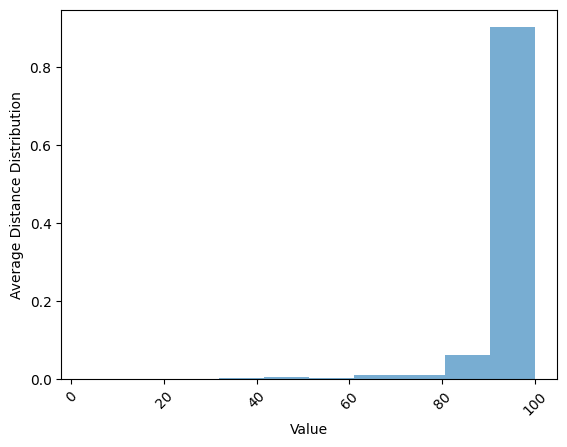

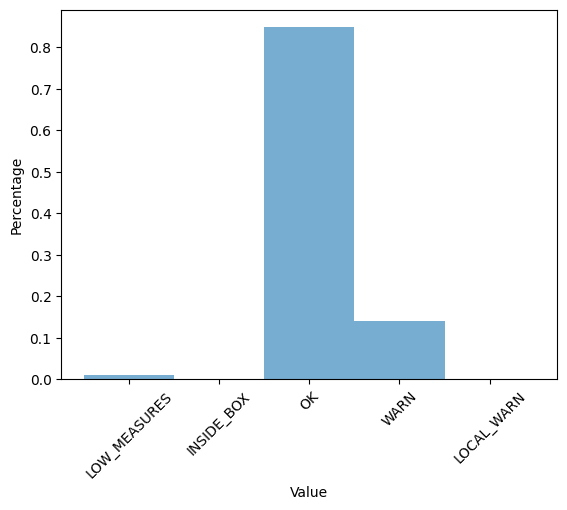

In [1]:
import save_load as sl
import transform as t

PATH = "home/unix/SmartBins_data"

ids = sl.load_id_containers(path = PATH)

container_dict = {id: sl.load_container_structured(id, path=PATH) for id in ids}

t.view_metrics(container_dict, box_window=7, mv_thresh = 70, min_days = 30, use = 'avg_dist')

Now we want to start looking to what might be wrong in those few bins. We start by getting the tags for all bins and plot the metrics of the some bins that have a **warn** tag in order to get a picture of where the time that strange things are happening in order to plot them after

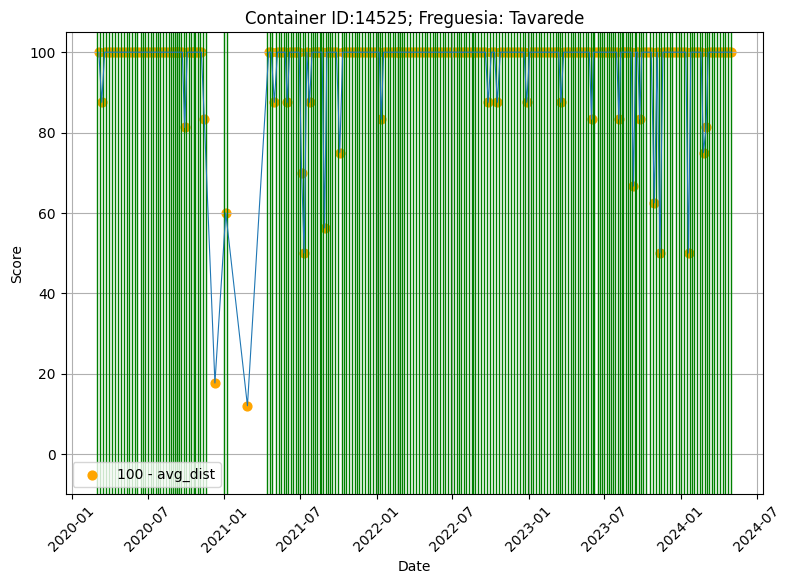

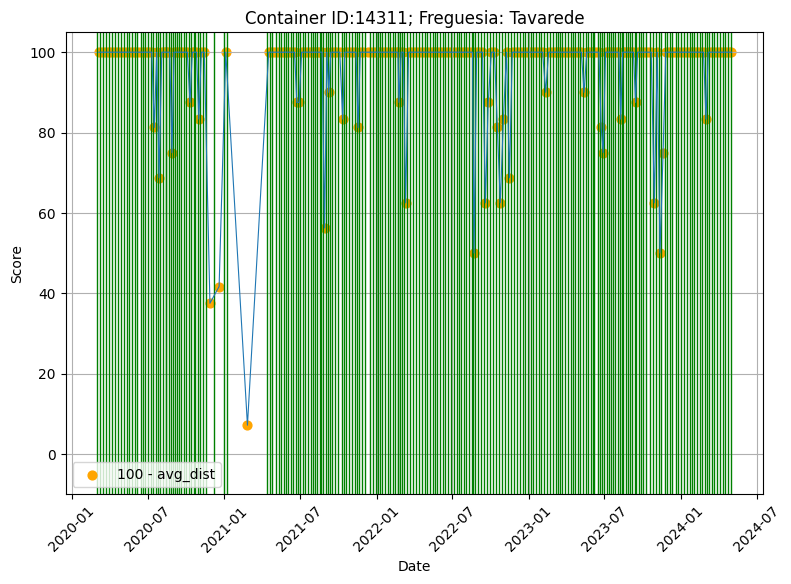

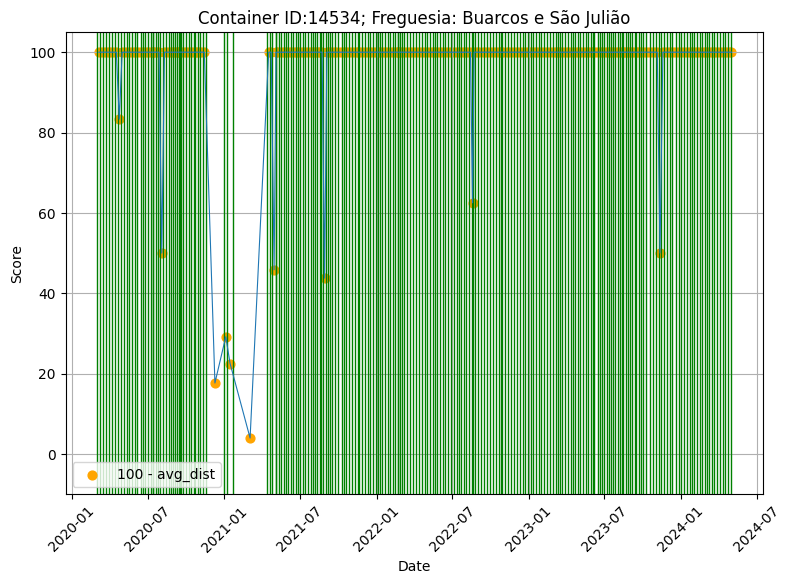

In [2]:
from Container import Container
from Container import TAG
import random

container:Container # type annotation
tags:list[TAG] = []

start_date = "01-01-2020"
end_date = "01-01-2025"

tags = [container.get_tag(window=7, mv_thresh = 70, min_days = 30, use = 'avg_dist') 
        for _, container in container_dict.items()]

warn_ids = [x[0] for x in random.sample(list(filter(lambda x: x[1] == TAG.WARN, zip(ids, tags))) , 3)]

for id in warn_ids:
    container_dict[id].plot_collection_metrics(start_date=start_date, end_date=end_date)

We also plot the the Containers tag with low measures, to infer what is happening. We conclude that those were containers added very recently that don't have enough datapoints to be considered

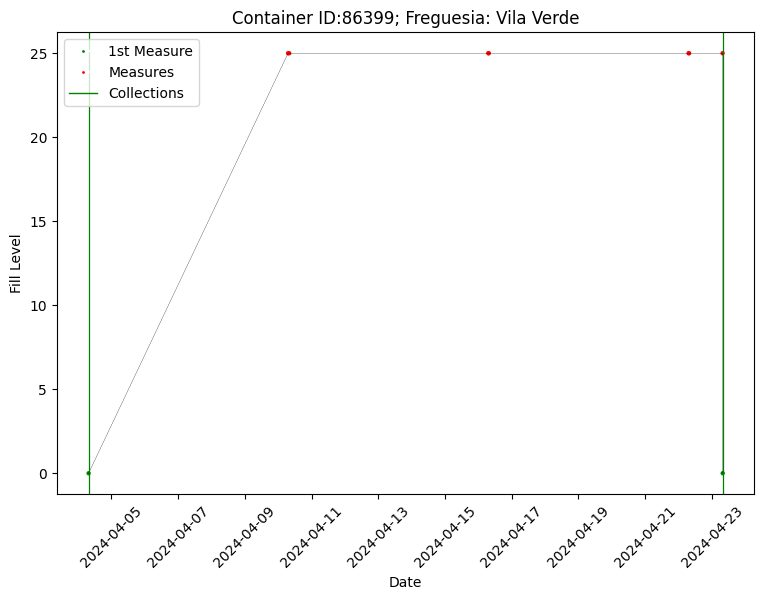

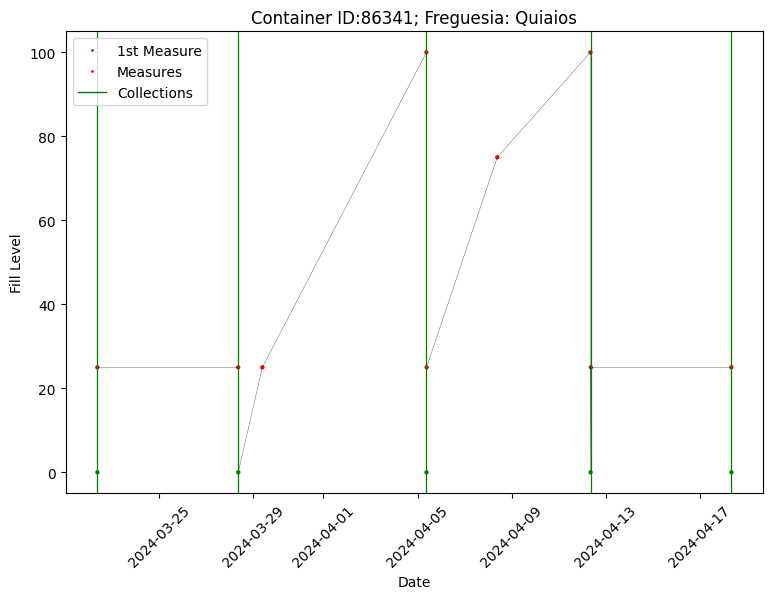

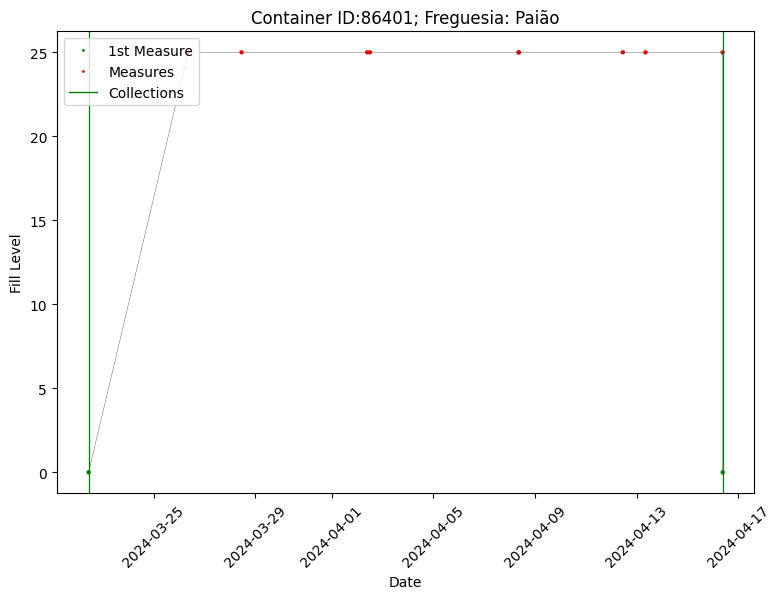

In [3]:
start_date = "01-01-2020"
end_date = "01-01-2025"

low_ids = [x[0] for x in random.sample(list(filter(lambda x: x[1] == TAG.LOW_MEASURES, zip(ids, tags))) , 3)]

for id in low_ids:
    container_dict[id].plot_fill(start_date=start_date, end_date=end_date)

Getting back again to the containers who have a warning tag, by running the command various times, we conclude that the main reason why these containers are tagged with a warning, is because there is a period from 2020 to 2021 where there seems not be collections. We plot these containers with their real values to see what is happening there. By looking at the images, we notice that collections are missing.

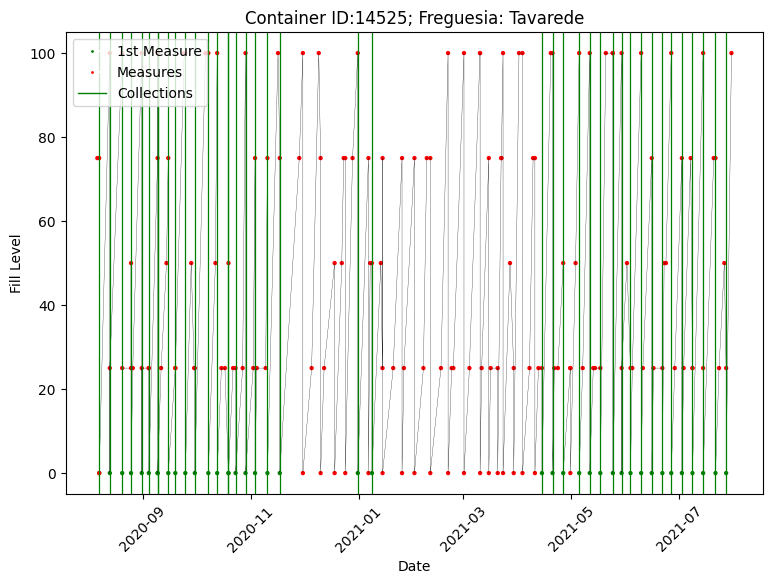

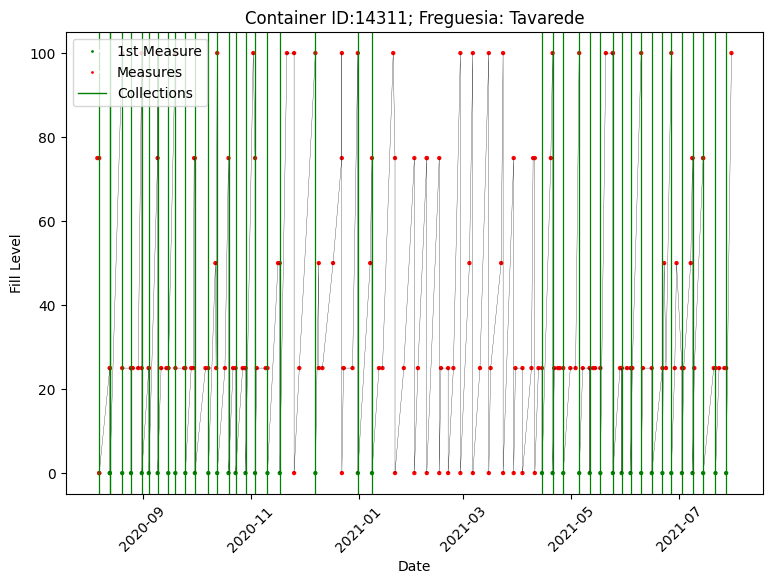

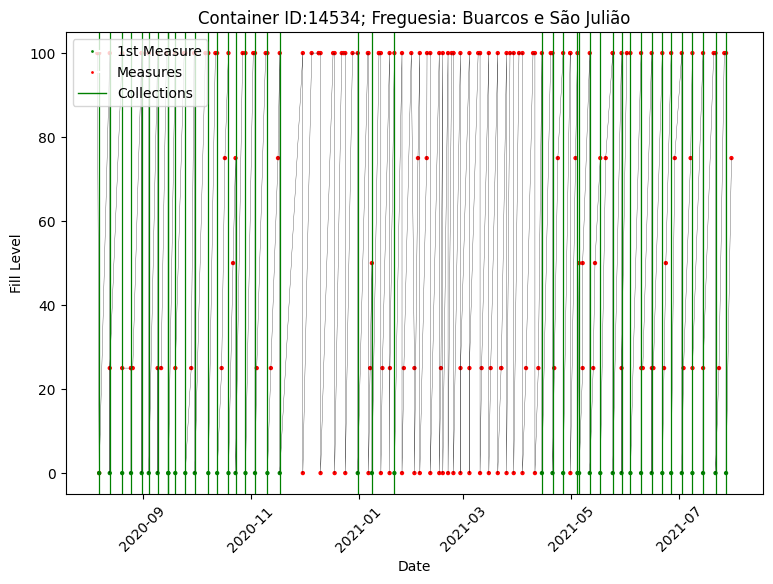

In [4]:
start_date = "01-08-2020"
end_date = "01-08-2021"

for id in warn_ids:
    container_dict[id].plot_fill(start_date=start_date, end_date=end_date)

We also plot on another time interval just to check what are the others low avg_Dist values

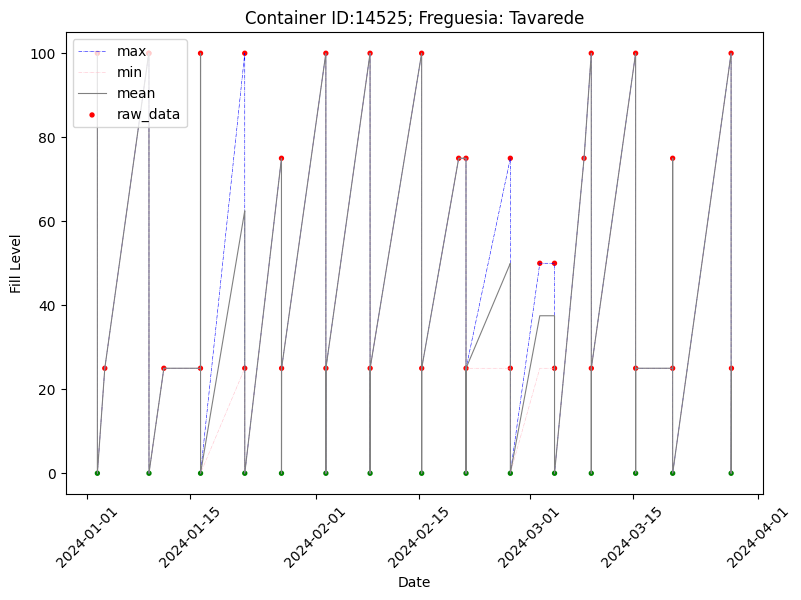

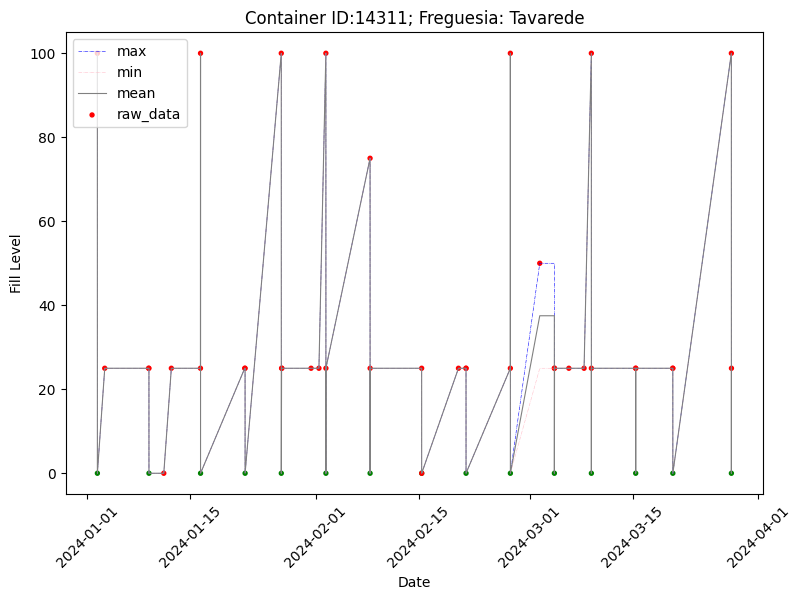

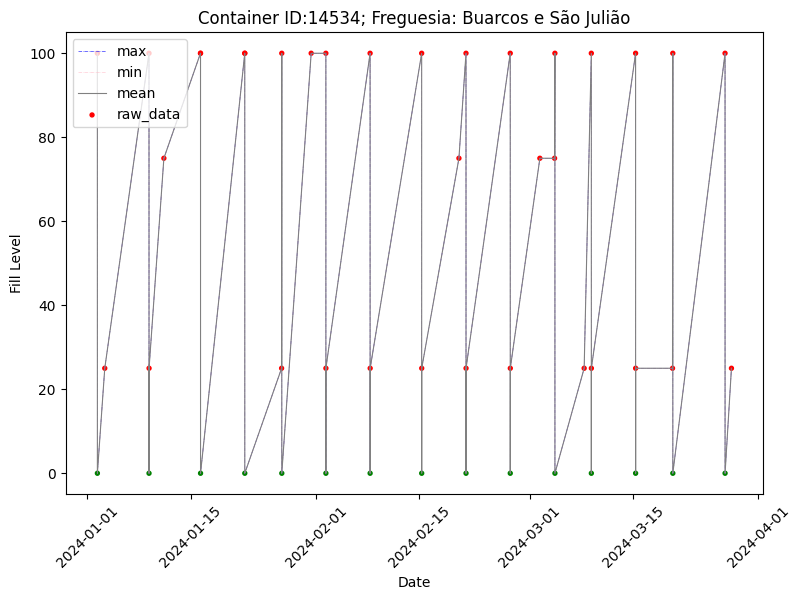

In [5]:
start_date = "01-01-2024"
end_date = "01-04-2024"

for id in warn_ids:
    container_dict[id].plot_max_min(start_date=start_date, end_date=end_date)
    fill, rec, info = container_dict[id].get_vars()

We notice that, in the three bins, the drivers make a value of 25 right before a collection, and a few of the times this is wrong. Our approach has been never to doubt measures, but only move collections, and default noisy behavior to the calculation of the approximated rate or the statistical analysis to preform. 

We will now try to fix the collections and see what happens o these bins. The parameters we set are very important
 - Avg_Dist threshold is set to 70 to tolerate mild differences of opinion among drivers. Everything below this threshold we will try to adjust.
 - collected junk is set to 24, to avoid placing collections on places that the trash is still building up.
 - max_fill is set to 1 because all collections happen with a marking of zero in series, and we ant to avoid marking collections with higher values.
 - dist_thresh plays a similar role as the window for tagging because we will only use average distance

Notice that there are two processes that will happen cooperatively. sometimes the adjust function will delete a collection for the place function to create a new one exactly there.

We plot also the dvar histogram. We set the variance threshold to very high for it not to intervene when messing with driver data. I plot the dvar here so that we have a better notion of what to expect when using this with sensors 

(array([  1.,   0.,   0.,   0.,  14., 186., 150.,  66., 610.,  68.]),
 array([-1.06434839e-02, -9.45757425e-03, -8.27166464e-03, -7.08575504e-03,
        -5.89984544e-03, -4.71393583e-03, -3.52802623e-03, -2.34211662e-03,
        -1.15620702e-03,  2.97025832e-05,  1.21561219e-03]),
 <BarContainer object of 10 artists>)

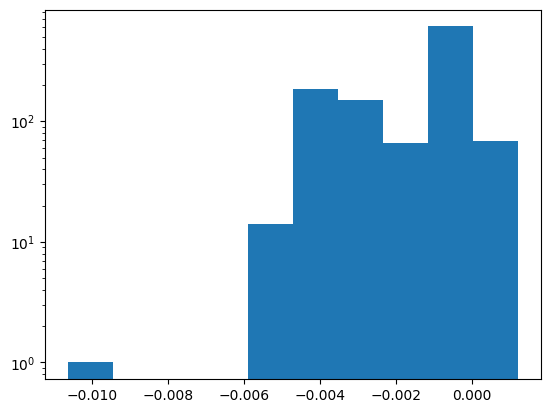

In [6]:
import matplotlib.pyplot as plt

dvarl = []

container:Container
for id, container in container_dict.items():
    dvar, _, container_dict[id] = t.fix_collections_sensor(container,
                             box_window = 7,
                             mv_thresh = 70,
                             min_days = 30,
                             max_fill = 1,
                             dist_thresh = 70,
                             c_trash = 0,
                             var_thresh = 200000000,
                             use = "avg_dist")
    dvarl.append(dvar)

plt.yscale('log')
plt.hist(dvarl)

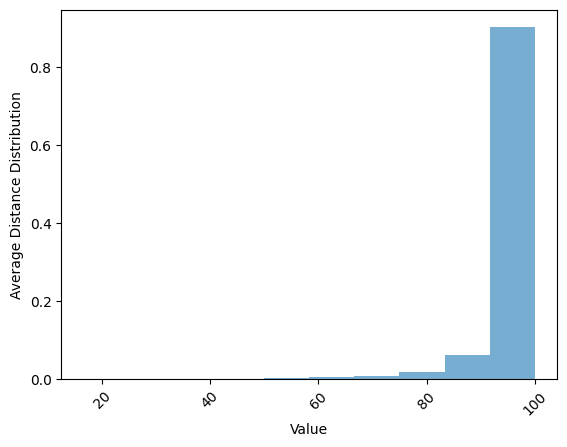

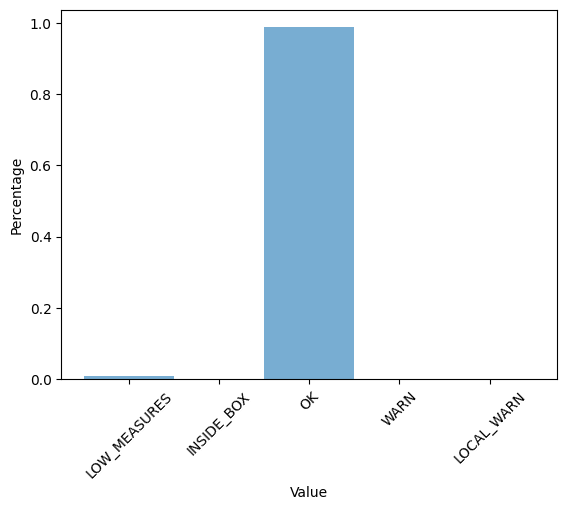

In [7]:
t.view_metrics(container_dict, box_window=7, mv_thresh = 70, min_days = 30, use = 'avg_dist')

Notice that by placing the collections on the appropriate places, we managed clear all the warnings that came up. Now we ae able to extract rates and save them with more knowledge of the quality of he data. notice that everything is not fixed, and that we we actually not able to place all the collections we would want. But now, these errors will appear like eventual outliers that can be easily be managed statistically by the prediction models. 

#### Extracting Rates

There are two ways to extract rates. By using mean monotonic approximation, that you can view by calling *container.plot_max_min_mean*; and by extracting them crudely. For  the drivers data my advice is to use the mean approximation, because it makes some sort of averaging of the drivers opinions. Because we have less data, we are not losing to much information by doing this.

Be aware that this will take 

In [9]:

PATH = "home/unix/SmartBins_data"

OK_Containers = t.filter_containers(containers_dict=container_dict)

container:Container
for id , container in OK_Containers.items():
    sl.save_rate_series(id=id, container=container, rate_type='mean', freq='1D', path=PATH) 

ids = list(OK_Containers.keys())

sl.save_id_containers(ids, path=PATH, name = "Rate_Ids")